In [1]:
import torch
torch.set_default_dtype(torch.float)
import pylibnxc
import numpy as np
from ase.io import read
from dpyscfl.net import *
from dpyscfl.scf import *
from dpyscfl.utils import *
from dpyscfl.losses import *
from ase.units import Bohr, Hartree
import os, sys, argparse, psutil, pickle, threading, signal
from opt_einsum import contract
import matplotlib.pyplot as plt

In [6]:
dct= {'a':1, "b":2, "c":4}
for idx, k in enumerate(dct):
    print(idx, k)

0 a
1 b
2 c


In [3]:
z = torch.tensor([0])

In [5]:
if z == 0:
    print('true')

true


In [7]:
rxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/calc_results.traj',':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [8]:
hbe = rxnw[48].calc.results['energy']

In [9]:
pte = rxnw[49].calc.results['energy']

In [10]:
print(hbe, pte)
y1 = (hbe-pte)*Hartree

-151.7212731852801 -151.73933198003712


In [11]:
xcdhb = -151.729431405722
xcdpt = -151.717912272695
y2 = (xcdhb-xcdpt)*Hartree

In [12]:
xcdwhb = -151.714352241818
xcdwpt = -151.705428641774
y3 = (xcdwhb - xcdwpt)*Hartree

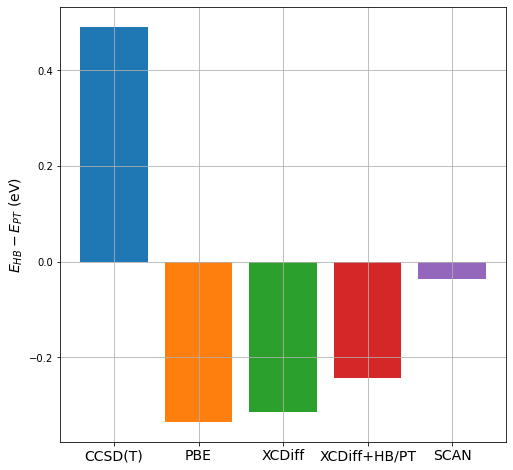

In [19]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
ax.bar(1, y1, label='CCSD(T)')
ax.bar(2, ypbe)
ax.bar(3, y2, label='XCDiff')
ax.bar(4, y3, label='XCDiff+HB/PT')
ax.bar(5, y4)
ax.set_xticks([1,2,3, 4,5])
ax.set_xticklabels(['CCSD(T)', 'PBE', 'XCDiff', 'XCDiff+HB/PT', 'SCAN'], fontsize=14)
ax.set_ylabel('$E_{HB} - E_{PT}$ (eV)', fontsize=14)
plt.grid()


In [40]:
y2/Hartree

-0.01151913302700791

In [2]:
def KS(mol, method, model_path='', nxc_kind='grid', **kwargs):
    """ Wrapper for the pyscf RKS and UKS class
    that uses a libnxc functionals
    """
    #hyb = kwargs.get('hyb', 0)
    mf = method(mol, **kwargs)
    if model_path != '':
        if nxc_kind.lower() == 'atomic':
            model = get_nxc_adapter('pyscf', model_path)
            mf.get_veff = veff_mod_atomic(mf, model)
        elif nxc_kind.lower() == 'grid':
            parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(model_path)
            dft.libxc.define_xc_(mf._numint,
                                 eval_xc,
                                 pylibnxc.pyscf.utils.find_max_level(parsed_xc),
                                 hyb=parsed_xc[0][0])
            mf.xc = model_path
        else:
            raise ValueError(
                "{} not a valid nxc_kind. Valid options are 'atomic' or 'grid'"
                .format(nxc_kind))
    return mf


def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, verbose=None):
    """ Evaluation for grid-based models (not atomic)
        See pyscf documentation of eval_xc
    """
    inp = {}
    if spin == 0:
        if rho.ndim == 1:
            rho = rho.reshape(1, -1)
        inp['rho'] = rho[0]
        if len(rho) > 1:
            dx, dy, dz = rho[1:4]
            gamma = (dx**2 + dy**2 + dz**2)
            inp['sigma'] = gamma
        if len(rho) > 4:
            inp['lapl'] = rho[4]
            inp['tau'] = rho[5]
    else:
        rho_a, rho_b = rho
        if rho_a.ndim == 1:
            rho_a = rho_a.reshape(1, -1)
            rho_b = rho_b.reshape(1, -1)
        inp['rho'] = np.stack([rho_a[0], rho_b[0]])
        if len(rho_a) > 1:
            dxa, dya, dza = rho_a[1:4]
            dxb, dyb, dzb = rho_b[1:4]
            gamma_a = (dxa**2 + dya**2 + dza**2)  #compute contracted gradients
            gamma_b = (dxb**2 + dyb**2 + dzb**2)
            gamma_ab = (dxb * dxa + dyb * dya + dzb * dza)
            inp['sigma'] = np.stack([gamma_a, gamma_ab, gamma_b])
        if len(rho_a) > 4:
            inp['lapl'] = np.stack([rho_a[4], rho_b[4]])
            inp['tau'] = np.stack([rho_a[5], rho_b[5]])

    parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(xc_code)
    total_output = {'v' + key: 0.0 for key in inp}
    total_output['zk'] = 0
    #print(parsed_xc)
    for code, factor in parsed_xc[1]:
        model = pylibnxc.LibNXCFunctional(xc_code, kind='grid')
        output = model.compute(inp)
        for key in output:
            if output[key] is not None:
                total_output[key] += output[key] * factor

    exc, vlapl, vtau, vrho, vsigma = [total_output.get(key,None)\
      for key in ['zk','vlapl','vtau','vrho','vsigma']]

    vxc = (vrho, vsigma, vlapl, vtau)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc

In [2]:
#HB
hb = gto.M(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='def2-TZVPD', unit='angstrom')
hb.verbose = 5
hb.charge = 1
hb.spin = 1

#PT
#equilibrium hemibonded configuration: r_{OO} = 2.05 \AA.
pt = gto.M(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='def2-TZVPD')
pt.verbose = 5
pt.charge = 1
pt.spin = 1

In [3]:
smfhb, _ = gen_mf_mol(hb, xc='pbe', grid_level=5)
smfpt, _ = gen_mf_mol(pt, xc='pbe', grid_level=5)
smfhb.kernel()
smfpt.kernel()

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: <function UKS at 0x7f8f9f57e3b0>
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  

  beta  mo_energy =
[-1.88639594e+01 -1.88639576e+01 -1.16101636e+00 -1.14557425e+00
 -7.22379825e-01 -7.09823619e-01 -5.59277299e-01 -5.51954603e-01
 -4.93898252e-01 -4.24735616e-01 -2.30013555e-01 -1.86274494e-01
 -1.45183414e-01 -1.27624454e-01 -9.75765756e-02 -7.38778493e-02
 -5.46710525e-02 -4.79427799e-02 -4.48107709e-02 -3.76030922e-02
 -3.72559688e-02  8.84773036e-03  2.54677735e-02  3.76696802e-02
  3.96161882e-02  8.69614893e-02  8.94216181e-02  9.14999543e-02
  1.11380885e-01  1.27594993e-01  1.33026910e-01  1.43283661e-01
  1.48762308e-01  1.50216427e-01  1.93392451e-01  2.07580269e-01
  2.47756075e-01  2.53826059e-01  2.82247615e-01  2.86654598e-01
  3.16808225e-01  3.25022575e-01  3.38346916e-01  3.62935192e-01
  4.16359018e-01  4.43504546e-01  4.91622687e-01  5.01321923e-01
  5.69496073e-01  5.71083908e-01  5.83521336e-01  6.31548899e-01
  6.95204209e-01  7.14808772e-01  7.16237324e-01  8.51984366e-01
  1.24315384e+00  1.27325833e+00  1.29608465e+00  1.31104660e+00
  1.3

  beta  mo_energy =
[-1.90898237e+01 -1.90898221e+01 -1.23191225e+00 -1.21680112e+00
 -7.79387144e-01 -7.67940811e-01 -6.41579678e-01 -6.38538160e-01
 -5.77974423e-01 -5.11215561e-01 -2.43296252e-01 -2.01585100e-01
 -1.62863199e-01 -1.47057391e-01 -1.09828789e-01 -7.89708270e-02
 -6.33297972e-02 -5.46609927e-02 -5.31827619e-02 -4.51882495e-02
 -4.24911097e-02  2.14243793e-03  2.20647287e-02  3.10873173e-02
  3.13052653e-02  7.70883642e-02  7.85063103e-02  7.89892100e-02
  9.81283241e-02  1.17070866e-01  1.22999032e-01  1.42481090e-01
  1.44376056e-01  1.44904399e-01  1.84154832e-01  1.96308447e-01
  2.36606288e-01  2.44914997e-01  2.68000997e-01  2.71345950e-01
  3.03202912e-01  3.09530773e-01  3.24773401e-01  3.49580195e-01
  4.08946611e-01  4.27888169e-01  4.63947231e-01  4.77897572e-01
  5.39271260e-01  5.48274460e-01  5.53140713e-01  6.12619077e-01
  6.68849230e-01  6.91949067e-01  6.92849749e-01  8.24589664e-01
  1.21788441e+00  1.24121786e+00  1.26580868e+00  1.28928515e+00
  1.2

  beta  mo_energy =
[-1.90899367e+01 -1.90899351e+01 -1.23173100e+00 -1.21660213e+00
 -7.79298166e-01 -7.67843219e-01 -6.41117635e-01 -6.37930007e-01
 -5.77047121e-01 -5.10261819e-01 -2.43394686e-01 -2.01690063e-01
 -1.62793605e-01 -1.47084668e-01 -1.09576209e-01 -7.88988769e-02
 -6.31653360e-02 -5.45987686e-02 -5.29845828e-02 -4.51183301e-02
 -4.24680441e-02  2.23079228e-03  2.20597667e-02  3.11195012e-02
  3.14000928e-02  7.72053479e-02  7.86500893e-02  7.91459271e-02
  9.82602214e-02  1.17297898e-01  1.23159099e-01  1.42518269e-01
  1.44514475e-01  1.45017340e-01  1.84212441e-01  1.96391956e-01
  2.36632832e-01  2.45088312e-01  2.68089919e-01  2.71480794e-01
  3.03294030e-01  3.09757500e-01  3.24866988e-01  3.49760053e-01
  4.08952771e-01  4.27892208e-01  4.63756314e-01  4.77828171e-01
  5.39393275e-01  5.48358958e-01  5.53299994e-01  6.12735640e-01
  6.69158766e-01  6.92119555e-01  6.93038371e-01  8.24668344e-01
  1.21782561e+00  1.24126723e+00  1.26580287e+00  1.28917951e+00
  1.2

  beta  mo_energy =
[-1.90898605e+01 -1.90898589e+01 -1.23171735e+00 -1.21658108e+00
 -7.79314072e-01 -7.67855991e-01 -6.41139506e-01 -6.37942696e-01
 -5.77041762e-01 -5.10254040e-01 -2.43428337e-01 -2.01712814e-01
 -1.62825214e-01 -1.47123660e-01 -1.09606119e-01 -7.89291274e-02
 -6.31946945e-02 -5.46426825e-02 -5.30167523e-02 -4.51585571e-02
 -4.25040679e-02  2.19171813e-03  2.20229312e-02  3.10891951e-02
  3.13640719e-02  7.71723248e-02  7.86234153e-02  7.91155269e-02
  9.82195887e-02  1.17275765e-01  1.23135075e-01  1.42481036e-01
  1.44479258e-01  1.44980329e-01  1.84163403e-01  1.96354729e-01
  2.36583736e-01  2.45051885e-01  2.68039740e-01  2.71437637e-01
  3.03248688e-01  3.09733627e-01  3.24825283e-01  3.49724999e-01
  4.08912322e-01  4.27859265e-01  4.63688788e-01  4.77783022e-01
  5.39370887e-01  5.48328070e-01  5.53266401e-01  6.12700473e-01
  6.69144728e-01  6.92082566e-01  6.93019517e-01  8.24612290e-01
  1.21777595e+00  1.24121849e+00  1.26576321e+00  1.28912711e+00
  1.2

  beta  mo_energy =
[-1.90898617e+01 -1.90898601e+01 -1.23171753e+00 -1.21658125e+00
 -7.79314765e-01 -7.67856707e-01 -6.41140024e-01 -6.37943084e-01
 -5.77042142e-01 -5.10254790e-01 -2.43428977e-01 -2.01713512e-01
 -1.62825849e-01 -1.47124717e-01 -1.09605837e-01 -7.89290263e-02
 -6.31943416e-02 -5.46429668e-02 -5.30163924e-02 -4.51587365e-02
 -4.25039559e-02  2.19186610e-03  2.20228881e-02  3.10889470e-02
  3.13641379e-02  7.71719836e-02  7.86234384e-02  7.91154684e-02
  9.82196642e-02  1.17276063e-01  1.23135434e-01  1.42480920e-01
  1.44479187e-01  1.44980278e-01  1.84163071e-01  1.96354859e-01
  2.36583671e-01  2.45051866e-01  2.68040054e-01  2.71437953e-01
  3.03248793e-01  3.09734015e-01  3.24825461e-01  3.49725157e-01
  4.08911811e-01  4.27858758e-01  4.63688430e-01  4.77782264e-01
  5.39370812e-01  5.48327567e-01  5.53266313e-01  6.12700756e-01
  6.69145011e-01  6.92082522e-01  6.93019755e-01  8.24612035e-01
  1.21777550e+00  1.24121815e+00  1.26576303e+00  1.28912656e+00
  1.2

nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      6.49 sec, wall time      0.44 sec
E1 = -283.5771715678624  Ecoul = 110.19652197023949  Exc = -18.395685268457118
cycle= 1 E= -152.321229753564  delta_E= 0.372  |g|= 0.411  |ddm|= 0.985
    CPU time for cycle= 1      7.25 sec, wall time      0.48 sec
  alpha nocc = 10  HOMO = -0.501141800217548  LUMO = -0.233561183601422
  beta  nocc = 9  HOMO = -0.482150047815247  LUMO = -0.449272408142908
  alpha mo_energy =
[-1.89533507e+01 -1.88098626e+01 -1.19895441e+00 -1.14711694e+00
 -7.58384778e-01 -7.46702856e-01 -6.32960516e-01 -5.70612069e-01
 -5.15806863e-01 -5.01141800e-01 -2.33561184e-01 -1.80877603e-01
 -1.46384777e-01 -1.10125358e-01 -1.02339161e-01 -9.47565914e-02
 -6.00054877e-02 -5.51696897e-02 -4.45487450e-02 -3.29564019e-02
 -6.67251755e-03 -1.62890414e-03  3.13379828e-03  4.18743069e-02
  4.41382713e-02  6.13182615e-02  7.08256215e-02  8.25262323e-02
  1.08483707e-01  1.20048109e-01  1.30571022e-01  1

multiplicity <S^2> = 0.7518428  2S+1 = 2.001842
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      6.26 sec, wall time      0.41 sec
E1 = -281.853202765849  Ecoul = 108.18802761330781  Exc = -18.164508479912797
cycle= 3 E= -152.374578519938  delta_E= -0.13  |g|= 0.0502  |ddm|= 0.28
    CPU time for cycle= 3      7.72 sec, wall time      0.49 sec
  alpha nocc = 10  HOMO = -0.571516888418008  LUMO = -0.249630764445472
  beta  nocc = 9  HOMO = -0.549405753821201  LUMO = -0.50264114314373
  alpha mo_energy =
[-1.91151411e+01 -1.91001379e+01 -1.28946938e+00 -1.20582887e+00
 -8.23361547e-01 -8.18858899e-01 -6.96438340e-01 -6.36181495e-01
 -6.16517982e-01 -5.71516888e-01 -2.49630764e-01 -1.92280880e-01
 -1.67754125e-01 -1.19902957e-01 -1.08378031e-01 -1.02600049e-01
 -7.03843152e-02 -6.07231387e-02 -4.97471889e-02 -3.69945669e-02
 -3.22558665e-02 -6.58706260e-03 -1.16470931e-03  3.22724940e-02
  4.12485681e-02  4.96961066e-02  5.78362304e-02  7.28667808e-02
  9.9

multiplicity <S^2> = 0.75226507  2S+1 = 2.0022638
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      6.05 sec, wall time      0.40 sec
E1 = -281.7799598850033  Ecoul = 108.10668453359196  Exc = -18.15739549984634
cycle= 5 E= -152.375565738742  delta_E= -0.000626  |g|= 0.00661  |ddm|= 0.0238
    CPU time for cycle= 5      6.97 sec, wall time      0.45 sec
  alpha nocc = 10  HOMO = -0.562720003492684  LUMO = -0.249183184208434
  beta  nocc = 9  HOMO = -0.540278854881873  LUMO = -0.491431278040819
  alpha mo_energy =
[-1.91063282e+01 -1.90919648e+01 -1.29074196e+00 -1.19691477e+00
 -8.23373497e-01 -8.19228866e-01 -6.89382979e-01 -6.28543077e-01
 -6.15761480e-01 -5.62720003e-01 -2.49183184e-01 -1.90108547e-01
 -1.67723550e-01 -1.18904672e-01 -1.07192823e-01 -1.01229833e-01
 -6.91346283e-02 -5.97116478e-02 -4.82958971e-02 -3.60747148e-02
 -3.08540547e-02 -5.71040370e-03 -1.84370022e-04  3.36596505e-02
  4.25051515e-02  5.04026008e-02  5.86611377e-02  7.42496191

multiplicity <S^2> = 0.7523635  2S+1 = 2.0023621
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      6.33 sec, wall time      0.43 sec
E1 = -281.7999504682036  Ecoul = 108.12946197693265  Exc = -18.160202329800878
cycle= 7 E= -152.375585708556  delta_E= -2.27e-06  |g|= 0.000839  |ddm|= 0.00312
    CPU time for cycle= 7      8.01 sec, wall time      0.53 sec
  alpha nocc = 10  HOMO = -0.562745913835911  LUMO = -0.249236930329038
  beta  nocc = 9  HOMO = -0.54020388995129  LUMO = -0.491298097804549
  alpha mo_energy =
[-1.91061635e+01 -1.90919787e+01 -1.29082187e+00 -1.19697922e+00
 -8.23486449e-01 -8.19325850e-01 -6.89423887e-01 -6.28515485e-01
 -6.15961364e-01 -5.62745914e-01 -2.49236930e-01 -1.90104150e-01
 -1.67808287e-01 -1.18978082e-01 -1.07177434e-01 -1.01268530e-01
 -6.92054903e-02 -5.97920679e-02 -4.82877216e-02 -3.61282346e-02
 -3.08527063e-02 -5.75634176e-03 -1.89165936e-04  3.36298658e-02
  4.24837482e-02  5.03655518e-02  5.86226818e-02  7.4212819

multiplicity <S^2> = 0.75237825  2S+1 = 2.0023768
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      6.22 sec, wall time      0.42 sec
E1 = -281.79980991997013  Ecoul = 108.12929796269863  Exc = -18.160181508325802
cycle= 9 E= -152.375588353081  delta_E= -9e-07  |g|= 0.000153  |ddm|= 0.00426
    CPU time for cycle= 9      7.28 sec, wall time      0.47 sec
  alpha nocc = 10  HOMO = -0.562731496602049  LUMO = -0.249218109448633
  beta  nocc = 9  HOMO = -0.540199600161547  LUMO = -0.491295921855086
  alpha mo_energy =
[-1.91061697e+01 -1.90919838e+01 -1.29078871e+00 -1.19697916e+00
 -8.23463899e-01 -8.19292160e-01 -6.89412205e-01 -6.28416011e-01
 -6.16026427e-01 -5.62731497e-01 -2.49218109e-01 -1.90102415e-01
 -1.67786726e-01 -1.18987744e-01 -1.07124906e-01 -1.01252839e-01
 -6.92079315e-02 -5.98024526e-02 -4.82597054e-02 -3.61199306e-02
 -3.08251036e-02 -5.74604981e-03 -1.65027054e-04  3.36250346e-02
  4.24853506e-02  5.03882053e-02  5.86250358e-02  7.4212200

multiplicity <S^2> = 0.75237219  2S+1 = 2.0023708
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      5.98 sec, wall time      0.39 sec
E1 = -281.79992786933394  Ecoul = 108.12942119711582  Exc = -18.160186849973783
cycle= 11 E= -152.375588409676  delta_E= -9.58e-10  |g|= 9.9e-06  |ddm|= 0.0001
    CPU time for cycle= 11      7.07 sec, wall time      0.45 sec
  alpha nocc = 10  HOMO = -0.562731166442854  LUMO = -0.24921720191252
  beta  nocc = 9  HOMO = -0.540202359962557  LUMO = -0.491298884007246
  alpha mo_energy =
[-1.91061671e+01 -1.90919818e+01 -1.29078677e+00 -1.19697795e+00
 -8.23461822e-01 -8.19289520e-01 -6.89412277e-01 -6.28413686e-01
 -6.16026378e-01 -5.62731166e-01 -2.49217202e-01 -1.90106594e-01
 -1.67785195e-01 -1.18987646e-01 -1.07124442e-01 -1.01253023e-01
 -6.92080407e-02 -5.98028590e-02 -4.82610812e-02 -3.61202786e-02
 -3.08241098e-02 -5.74586052e-03 -1.65698706e-04  3.36233544e-02
  4.24834218e-02  5.03885675e-02  5.86246434e-02  7.42106

-152.37558840971195

In [15]:
smfhb.get_k()

array([[[ 5.31577746,  4.10710619,  1.33778146, ...,  0.04608588,
          0.00709484, -0.01378128],
        [ 4.10710619,  3.7037801 ,  1.59072365, ...,  0.09361958,
          0.01260072, -0.02747592],
        [ 1.33778146,  1.59072365,  1.58429732, ...,  0.21100023,
          0.02700305, -0.06085825],
        ...,
        [ 0.04608588,  0.09361958,  0.21100023, ...,  0.14648611,
          0.0261991 , -0.03905741],
        [ 0.00709484,  0.01260072,  0.02700305, ...,  0.0261991 ,
          0.14663798, -0.07985603],
        [-0.01378128, -0.02747592, -0.06085825, ..., -0.03905741,
         -0.07985603,  0.205401  ]],

       [[ 5.30862855,  4.09686581,  1.33212563, ...,  0.04575135,
          0.00726694, -0.01380413],
        [ 4.09686581,  3.66907845,  1.54579174, ...,  0.08999929,
          0.01178807, -0.0263085 ],
        [ 1.33212563,  1.54579174,  1.47561813, ...,  0.20080638,
          0.02363749, -0.05719539],
        ...,
        [ 0.04575135,  0.08999929,  0.20080638, ...,  

In [15]:
ypbe = (smfhb.e_tot - smfpt.e_tot)*Hartree

In [4]:
smfhb, _ = gen_mf_mol(hb, xc='scan', grid_level=5)
smfpt, _ = gen_mf_mol(pt, xc='scan', grid_level=5)
smfhb.kernel()
smfpt.kernel()

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: <function UKS at 0x7f35f117b3b0>
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  

  beta  mo_energy =
[-1.90917135e+01 -1.90917121e+01 -1.21754992e+00 -1.20166770e+00
 -7.48090710e-01 -7.35588699e-01 -5.84552918e-01 -5.81126217e-01
 -5.06397483e-01 -4.27578058e-01 -1.99388738e-01 -1.54867546e-01
 -1.13080140e-01 -9.23131099e-02 -7.23472340e-02 -4.58861282e-02
 -2.63233427e-02 -2.19461941e-02 -1.55713962e-02 -1.47987600e-02
 -2.76750908e-03  4.20021663e-02  6.38887321e-02  6.60423574e-02
  7.49657755e-02  1.21804774e-01  1.24515143e-01  1.27223318e-01
  1.48809820e-01  1.71221435e-01  1.72004534e-01  1.90078434e-01
  1.95861719e-01  1.97163524e-01  2.41224606e-01  2.52165519e-01
  2.89995761e-01  3.10281017e-01  3.23041917e-01  3.32041057e-01
  3.60181293e-01  3.81734652e-01  3.82607017e-01  4.14868176e-01
  4.79431296e-01  5.06275789e-01  5.46191451e-01  5.53535711e-01
  6.27935992e-01  6.39436855e-01  6.46231400e-01  6.87102552e-01
  7.51055201e-01  7.76141689e-01  7.80227648e-01  9.25626896e-01
  1.32360323e+00  1.35146224e+00  1.37429911e+00  1.38982845e+00
  1.4

  beta  mo_energy =
[-1.92912955e+01 -1.92912943e+01 -1.27532967e+00 -1.25958061e+00
 -7.97267485e-01 -7.85487232e-01 -6.56104013e-01 -6.56000538e-01
 -5.73056579e-01 -4.95490703e-01 -2.11228966e-01 -1.67647542e-01
 -1.28090124e-01 -1.11194612e-01 -8.00871367e-02 -4.90326442e-02
 -3.18743098e-02 -2.54519665e-02 -2.53234716e-02 -1.90143579e-02
 -7.36942375e-03  3.56199316e-02  5.63063946e-02  6.00688188e-02
  7.13891391e-02  1.10369398e-01  1.16155166e-01  1.21064292e-01
  1.36431487e-01  1.61276248e-01  1.62342805e-01  1.85784633e-01
  1.91050044e-01  1.95571790e-01  2.32519245e-01  2.42078745e-01
  2.79549052e-01  3.02348866e-01  3.08979831e-01  3.17219198e-01
  3.47068106e-01  3.68746950e-01  3.69686125e-01  4.02415838e-01
  4.71696455e-01  4.90142169e-01  5.16671198e-01  5.41404717e-01
  6.00111791e-01  6.17226375e-01  6.18077650e-01  6.73159929e-01
  7.29289407e-01  7.58186269e-01  7.58486916e-01  9.00988614e-01
  1.30017136e+00  1.32358849e+00  1.34724025e+00  1.36893986e+00
  1.3

  beta  mo_energy =
[-1.92917505e+01 -1.92917493e+01 -1.27505541e+00 -1.25930408e+00
 -7.97914396e-01 -7.86087221e-01 -6.55727549e-01 -6.55668754e-01
 -5.71441765e-01 -4.93378904e-01 -2.11703287e-01 -1.68062437e-01
 -1.28352994e-01 -1.11685689e-01 -8.01125894e-02 -4.90784292e-02
 -3.19650204e-02 -2.58611692e-02 -2.53759684e-02 -1.92248762e-02
 -7.79317713e-03  3.51707149e-02  5.58216565e-02  5.94772153e-02
  7.10284094e-02  1.09844547e-01  1.15745949e-01  1.20782160e-01
  1.36090753e-01  1.61003567e-01  1.62195571e-01  1.85337185e-01
  1.90616839e-01  1.95187707e-01  2.31866219e-01  2.41627735e-01
  2.78785022e-01  3.01915258e-01  3.08122330e-01  3.16647170e-01
  3.46297966e-01  3.67975492e-01  3.69288438e-01  4.01990672e-01
  4.71147762e-01  4.89669235e-01  5.15761310e-01  5.40701653e-01
  5.99639430e-01  6.16638082e-01  6.17663869e-01  6.72325689e-01
  7.29283756e-01  7.57786445e-01  7.57876702e-01  9.00151693e-01
  1.29903327e+00  1.32269054e+00  1.34632847e+00  1.36780881e+00
  1.3

  beta  mo_energy =
[-1.92916484e+01 -1.92916472e+01 -1.27498758e+00 -1.25922803e+00
 -7.97887629e-01 -7.86054830e-01 -6.55694561e-01 -6.55644967e-01
 -5.71408579e-01 -4.93340255e-01 -2.11746693e-01 -1.68094930e-01
 -1.28383176e-01 -1.11734161e-01 -8.01262805e-02 -4.90950062e-02
 -3.19804587e-02 -2.59007572e-02 -2.53967084e-02 -1.92457305e-02
 -7.82807007e-03  3.51352424e-02  5.58134750e-02  5.94402157e-02
  7.09998185e-02  1.09844293e-01  1.15743018e-01  1.20770120e-01
  1.36057000e-01  1.60988310e-01  1.62186803e-01  1.85306493e-01
  1.90604134e-01  1.95163158e-01  2.31833584e-01  2.41603345e-01
  2.78743660e-01  3.01892992e-01  3.08076319e-01  3.16605739e-01
  3.46262294e-01  3.67936148e-01  3.69258505e-01  4.01952366e-01
  4.71111560e-01  4.89644705e-01  5.15708954e-01  5.40668973e-01
  5.99641187e-01  6.16617078e-01  6.17655122e-01  6.72293676e-01
  7.29288321e-01  7.57776461e-01  7.57855786e-01  9.00085672e-01
  1.29898726e+00  1.32264889e+00  1.34630964e+00  1.36776280e+00
  1.3

  beta  mo_energy =
[-1.92916477e+01 -1.92916466e+01 -1.27498758e+00 -1.25922788e+00
 -7.97887751e-01 -7.86055040e-01 -6.55692987e-01 -6.55644430e-01
 -5.71409681e-01 -4.93342747e-01 -2.11747189e-01 -1.68095408e-01
 -1.28381984e-01 -1.11734959e-01 -8.01244874e-02 -4.90926785e-02
 -3.19790924e-02 -2.59018227e-02 -2.53952693e-02 -1.92461563e-02
 -7.82572102e-03  3.51386834e-02  5.58150557e-02  5.94439420e-02
  7.10039555e-02  1.09848929e-01  1.15747076e-01  1.20775568e-01
  1.36061408e-01  1.60992498e-01  1.62194088e-01  1.85313135e-01
  1.90612432e-01  1.95171199e-01  2.31842049e-01  2.41609952e-01
  2.78747319e-01  3.01899851e-01  3.08080382e-01  3.16608029e-01
  3.46266115e-01  3.67938258e-01  3.69263068e-01  4.01954569e-01
  4.71114984e-01  4.89651815e-01  5.15713379e-01  5.40674985e-01
  5.99646066e-01  6.16620898e-01  6.17661008e-01  6.72297882e-01
  7.29289227e-01  7.57778407e-01  7.57859153e-01  9.00086282e-01
  1.29898898e+00  1.32265193e+00  1.34631213e+00  1.36776296e+00
  1.3

cycle= 1 E= -152.44049118747  delta_E= 0.332  |g|= 0.383  |ddm|= 0.988
    CPU time for cycle= 1     13.69 sec, wall time      1.17 sec
  alpha nocc = 10  HOMO = -0.529373256101587  LUMO = -0.205450342138627
  beta  nocc = 9  HOMO = -0.508329361866136  LUMO = -0.426839429831541
  alpha mo_energy =
[-1.91779891e+01 -1.90415480e+01 -1.26639281e+00 -1.21533219e+00
 -7.86049316e-01 -7.74085812e-01 -6.61978993e-01 -6.04633036e-01
 -5.46347505e-01 -5.29373256e-01 -2.05450342e-01 -1.52636532e-01
 -1.14058616e-01 -8.42284533e-02 -7.42428352e-02 -6.60963103e-02
 -2.97124703e-02 -2.22773488e-02 -1.85700096e-02 -3.28855173e-03
  1.49097719e-02  2.89571929e-02  3.69199449e-02  6.97854399e-02
  7.99202847e-02  8.83099847e-02  9.87331010e-02  1.14816524e-01
  1.38220942e-01  1.56117263e-01  1.67433110e-01  1.76462995e-01
  1.96533706e-01  2.24710390e-01  2.48084692e-01  2.70343330e-01
  2.83000379e-01  2.92830990e-01  2.96919861e-01  3.30920204e-01
  3.69140780e-01  3.78410508e-01  3.86918847e-01  4

multiplicity <S^2> = 0.75307652  2S+1 = 2.0030742
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.50 sec, wall time      1.15 sec
E1 = -282.0513677908552  Ecoul = 108.41908054499788  Exc = -18.309530093500996
cycle= 3 E= -152.486712226842  delta_E= -0.0738  |g|= 0.0436  |ddm|= 0.206
    CPU time for cycle= 3     14.41 sec, wall time      1.26 sec
  alpha nocc = 10  HOMO = -0.585820333632729  LUMO = -0.21744471232809
  beta  nocc = 9  HOMO = -0.562001547074534  LUMO = -0.46247305266962
  alpha mo_energy =
[-1.93111133e+01 -1.93011458e+01 -1.34259889e+00 -1.26248617e+00
 -8.40238198e-01 -8.35325978e-01 -7.12196084e-01 -6.60584820e-01
 -6.33225834e-01 -5.85820334e-01 -2.17444712e-01 -1.59188964e-01
 -1.29479967e-01 -8.95380069e-02 -7.82771078e-02 -6.99273367e-02
 -3.51469124e-02 -2.66242981e-02 -2.10246658e-02 -6.32633331e-03
 -3.50628587e-03  2.77237439e-02  3.62498961e-02  6.15417316e-02
  7.87586261e-02  8.04055020e-02  9.02180048e-02  1.10805090e-01


multiplicity <S^2> = 0.75396232  2S+1 = 2.0039584
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.40 sec, wall time      1.09 sec
E1 = -281.91897084939757  Ecoul = 108.27075604445855  Exc = -18.29431726738229
cycle= 5 E= -152.487426959805  delta_E= -0.000342  |g|= 0.00765  |ddm|= 0.0187
    CPU time for cycle= 5     14.00 sec, wall time      1.18 sec
  alpha nocc = 10  HOMO = -0.578842721961488  LUMO = -0.21735061249564
  beta  nocc = 9  HOMO = -0.554471988996034  LUMO = -0.453194502875849
  alpha mo_energy =
[-1.93070420e+01 -1.92925341e+01 -1.34481875e+00 -1.25563154e+00
 -8.41131940e-01 -8.36812166e-01 -7.06670271e-01 -6.54068179e-01
 -6.34119602e-01 -5.78842722e-01 -2.17350612e-01 -1.57172994e-01
 -1.29627125e-01 -8.90188602e-02 -7.76061830e-02 -6.89855192e-02
 -3.44232423e-02 -2.61325508e-02 -1.99728104e-02 -5.83452395e-03
 -2.92997644e-03  2.82078292e-02  3.69176759e-02  6.25302678e-02
  7.95167198e-02  8.09560590e-02  9.08896964e-02  1.12024034

multiplicity <S^2> = 0.75414046  2S+1 = 2.0041362
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.30 sec, wall time      1.08 sec
E1 = -281.93990567340035  Ecoul = 108.29485424709144  Exc = -18.29750968588625
cycle= 7 E= -152.487455999679  delta_E= -4.95e-06  |g|= 0.00109  |ddm|= 0.00356
    CPU time for cycle= 7     13.47 sec, wall time      1.15 sec
  alpha nocc = 10  HOMO = -0.578945033233862  LUMO = -0.217414356863721
  beta  nocc = 9  HOMO = -0.554308775554799  LUMO = -0.453008641259603
  alpha mo_energy =
[-1.93069014e+01 -1.92925066e+01 -1.34487216e+00 -1.25574775e+00
 -8.41216641e-01 -8.36887212e-01 -7.06750980e-01 -6.54046923e-01
 -6.34281475e-01 -5.78945033e-01 -2.17414357e-01 -1.57153526e-01
 -1.29717117e-01 -8.90879857e-02 -7.75958487e-02 -6.90266787e-02
 -3.44907406e-02 -2.62144776e-02 -1.99516050e-02 -5.84346322e-03
 -2.95407293e-03  2.81719541e-02  3.69049619e-02  6.24995979e-02
  7.94678670e-02  8.09314420e-02  9.08585694e-02  1.119652

multiplicity <S^2> = 0.75418651  2S+1 = 2.0041821
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.29 sec, wall time      1.21 sec
E1 = -281.9399375282827  Ecoul = 108.29490357453761  Exc = -18.297535984589512
cycle= 9 E= -152.487464825819  delta_E= -3.98e-06  |g|= 0.000427  |ddm|= 0.00625
    CPU time for cycle= 9     14.16 sec, wall time      1.31 sec
  alpha nocc = 10  HOMO = -0.578911930420702  LUMO = -0.217392525669214
  beta  nocc = 9  HOMO = -0.554357034819087  LUMO = -0.453030921261309
  alpha mo_energy =
[-1.93068887e+01 -1.92925241e+01 -1.34485165e+00 -1.25574448e+00
 -8.41221222e-01 -8.36864164e-01 -7.06753491e-01 -6.53912575e-01
 -6.34399268e-01 -5.78911930e-01 -2.17392526e-01 -1.57143178e-01
 -1.29693086e-01 -8.91249202e-02 -7.75166742e-02 -6.90101713e-02
 -3.45144879e-02 -2.62415043e-02 -1.98966429e-02 -5.84304658e-03
 -2.93875097e-03  2.81946597e-02  3.69229464e-02  6.24921653e-02
  7.94430685e-02  8.09546403e-02  9.08595490e-02  1.11956

multiplicity <S^2> = 0.75416556  2S+1 = 2.0041612
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.49 sec, wall time      1.12 sec
E1 = -281.94004369553693  Ecoul = 108.2950008287595  Exc = -18.297528545360862
cycle= 11 E= -152.487466299622  delta_E= -7.67e-08  |g|= 3.13e-05  |ddm|= 0.00119
    CPU time for cycle= 11     13.56 sec, wall time      1.18 sec
  alpha nocc = 10  HOMO = -0.57890946681074  LUMO = -0.217382585979257
  beta  nocc = 9  HOMO = -0.55435248531856  LUMO = -0.45303808176545
  alpha mo_energy =
[-1.93068878e+01 -1.92925037e+01 -1.34483448e+00 -1.25573622e+00
 -8.41205314e-01 -8.36845262e-01 -7.06746338e-01 -6.53886738e-01
 -6.34400776e-01 -5.78909467e-01 -2.17382586e-01 -1.57149713e-01
 -1.29681167e-01 -8.91266505e-02 -7.75031685e-02 -6.90049523e-02
 -3.45131626e-02 -2.62412945e-02 -1.98922510e-02 -5.83878133e-03
 -2.93064369e-03  2.82014421e-02  3.69288351e-02  6.24921846e-02
  7.94428124e-02  8.09618687e-02  9.08637703e-02  1.119599

multiplicity <S^2> = 0.75416567  2S+1 = 2.0041613
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     12.39 sec, wall time      1.20 sec
E1 = -281.9400499799317  Ecoul = 108.29500656424592  Exc = -18.297528002437158
cycle= 13 E= -152.487466305607  delta_E= -1.53e-10  |g|= 8.08e-06  |ddm|= 5.41e-05
    CPU time for cycle= 13     13.36 sec, wall time      1.25 sec
  alpha nocc = 10  HOMO = -0.578910676941657  LUMO = -0.217382522050366
  beta  nocc = 9  HOMO = -0.554351110800037  LUMO = -0.453038554576646
  alpha mo_energy =
[-1.93068841e+01 -1.92925051e+01 -1.34483404e+00 -1.25573620e+00
 -8.41205001e-01 -8.36844775e-01 -7.06746364e-01 -6.53885618e-01
 -6.34400586e-01 -5.78910677e-01 -2.17382522e-01 -1.57149607e-01
 -1.29681101e-01 -8.91267834e-02 -7.75027592e-02 -6.90048593e-02
 -3.45132317e-02 -2.62414382e-02 -1.98920720e-02 -5.83854176e-03
 -2.93052190e-03  2.82015635e-02  3.69291076e-02  6.24921823e-02
  7.94429649e-02  8.09620280e-02  9.08640863e-02  1.11

-152.48746630558583

In [5]:
y4 = (smfhb.e_tot - smfpt.e_tot)*Hartree

In [6]:
_, hbm = gen_mf_mol(hb, xc='notnull', grid_level=5, nxc=True)
_, ptm = gen_mf_mol(pt, xc='notnull', grid_level=5, nxc=True)

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: functools.partial(<function KS at 0x7fcb8db678c0>, method=<function UKS at 0x7fcb7b9a1320>)
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50

In [7]:
xcdwp = '/home/awills/Documents/Research/swxcd/eval/xcdw5/MODEL_MGGA_e29_day4/xc'
xcdp = '/home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA'
hbmf = KS(hb, hbm, model_path=xcdp, nxc_kind='grid')
ptmf = KS(pt, ptm, model_path=xcdp, nxc_kind='grid')

In [8]:
hbmf.grids.level = 5
hbmf.density_fit()
hbmf.kernel()

ptmf.grids.level = 5
ptmf.density_fit()
ptmf.kernel()



******** <class 'pyscf.dft.uks.UKS'> ********
method = UKS-UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmpv1af6f1q
max_memory 4000 MB (current use 871 MB)
number electrons alpha = 10  beta = 9
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = /home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA


KeyError: 'Unknown compound XC functional  /HOME/AWILLS/DOCUMENTS/RESEARCH/DPYSCFL/MODELS/XCDIFF/MODEL_MGGA'

In [1]:
tstd = {'E': 0}
tstd2 = {'rho': 0}
tstd3 = {'rho':0, 'E':0}

In [3]:
'rho' in tstd2.keys()

True

In [26]:
rp = '/home/awills/Documents/Research/swxcd/seawulf/g297/'
rt = 'results.traj'
atoms = read(os.path.join(rp, rt), ':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [27]:
atoms

[Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='S2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='SH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='OS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='C2H', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CF4', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CH4', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='SCS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='FOF', pbc=False, calculator=SinglePointCalc

In [23]:
atoms[48].get_chemical_symbols()

['O', 'H', 'H', 'O', 'H', 'H']

In [28]:
symbs = []
for at in atoms:
    symbs += at.get_chemical_symbols()
symbs = list(set(symbs))

In [29]:
symbs

['N', 'S', 'C', 'Li', 'Be', 'Na', 'Si', 'Al', 'H', 'O', 'F', 'P', 'B', 'Cl']

In [19]:
symbats = [Atoms(symbols=s) for s in symbs]

In [21]:
symbmols = [ase_atoms_to_mol(at) for at in symbats]

In [22]:
symbmols

[('N', <pyscf.gto.mole.Mole at 0x7fcb702124d0>),
 ('Li', <pyscf.gto.mole.Mole at 0x7fcb77c499d0>),
 ('C', <pyscf.gto.mole.Mole at 0x7fcb782cb190>),
 ('Na', <pyscf.gto.mole.Mole at 0x7fcb77c5dad0>),
 ('H', <pyscf.gto.mole.Mole at 0x7fcb77f892d0>),
 ('O', <pyscf.gto.mole.Mole at 0x7fcb77d11ed0>),
 ('F', <pyscf.gto.mole.Mole at 0x7fcb706c0550>),
 ('Cl', <pyscf.gto.mole.Mole at 0x7fcb782cf790>)]

In [25]:
gen_mf_mol??